In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as smt
# from statsmodels.tsa.statsmodels import 


In [2]:
data = pd.read_csv('dataframe_full.csv')

In [3]:
data = data.set_index('Date')
data.shape

(1260, 14373)

In [4]:
data.columns

Index(['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume',
       'AAPL_Dividends', 'AAPL_Stock_Splits', 'A_Open', 'A_High', 'A_Low',
       ...
       'ZUO_Volume', 'ZUO_Dividends', 'ZUO_Stock Splits', 'ZWS_Open',
       'ZWS_High', 'ZWS_Low', 'ZWS_Close', 'ZWS_Volume', 'ZWS_Dividends',
       'ZWS_Stock Splits'],
      dtype='object', length=14373)

In [5]:
### Get unique list of stock symbols still in dataframe

stock_symbol_list = []
for a in data.columns:
    symbol = a.split('_')[0]
    if symbol not in stock_symbol_list:
        stock_symbol_list.append(symbol)
        

In [6]:
len(stock_symbol_list)

2053

In [7]:
### Get open price for all stocks

stock_open_price_col_list = []
for a in data.columns:
    symbol = a.split('_')[0]
    col_name = symbol + '_Open'
    if col_name not in stock_open_price_col_list:
        stock_open_price_col_list.append(col_name)

data_open = data[stock_open_price_col_list]


In [8]:
### Get volume for all stocks

stock_volume_col_list = []
for a in data.columns:
    symbol = a.split('_')[0]
    col_name = symbol + '_Volume'
    if col_name not in stock_volume_col_list:
        stock_volume_col_list.append(col_name)

data_volume = data[stock_volume_col_list]


In [9]:
### Get HIGH for all stocks

stock_high_col_list = []
for a in data.columns:
    symbol = a.split('_')[0]
    col_name = symbol + '_High'
    if col_name not in stock_high_col_list:
        stock_high_col_list.append(col_name)

data_high = data[stock_high_col_list]


In [10]:
### Get low for all stocks

stock_low_col_list = []
for a in data.columns:
    symbol = a.split('_')[0]
    col_name = symbol + '_Low'
    if col_name not in stock_low_col_list:
        stock_low_col_list.append(col_name)

data_low = data[stock_low_col_list]


In [11]:
### Get close for all stocks

stock_close_col_list = []
for a in data.columns:
    symbol = a.split('_')[0]
    col_name = symbol + '_Close'
    if col_name not in stock_close_col_list:
        stock_close_col_list.append(col_name)

data_close = data[stock_close_col_list]


In [12]:
aux_data = pd.read_csv('./Aux_Data/AAPL.csv')


# Visualization of data

In [13]:
apple_open = data_open['AAPL_Open']

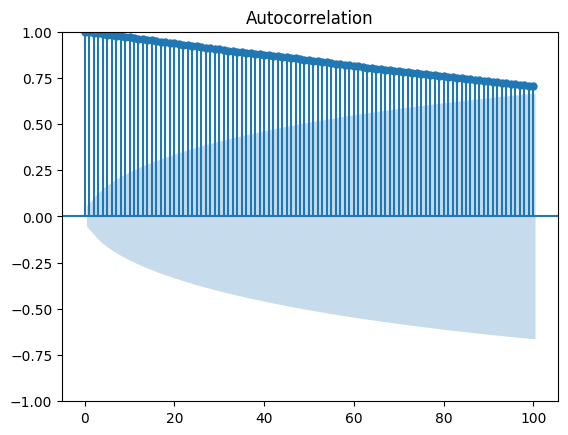

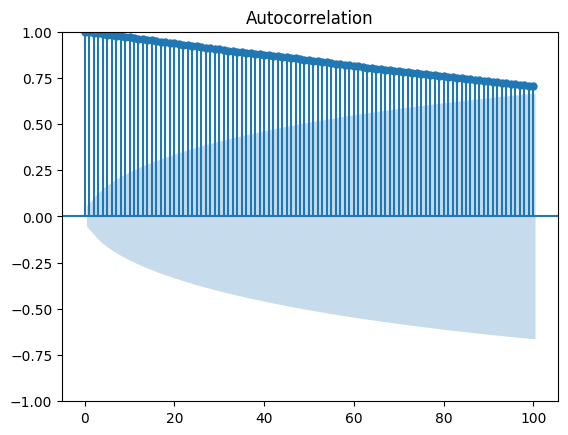

In [14]:
plot_acf(apple_open, lags=100)

0.10247922620179216 0.16787962553436842


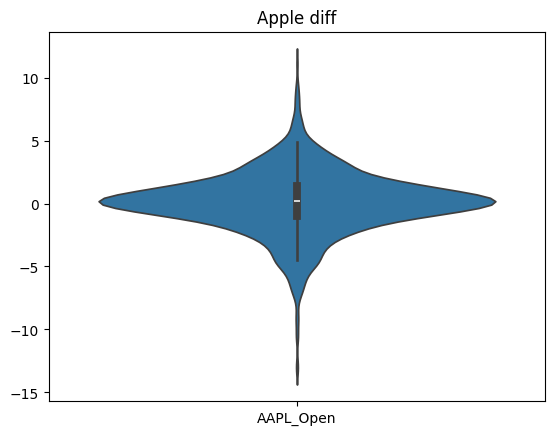

In [15]:
apple_diff = pd.DataFrame(data_open['AAPL_Open']).diff().dropna()
sns.violinplot(apple_diff)
print(np.mean(apple_diff), np.median(apple_diff))
plt.title('Apple diff')
plt.show()

# Multivariate analysis
first getting cross correlation of data to aapl

In [16]:
forwards = smt.ccf(data_open['AAPL_Open'],data_open['NVDA_Open'], adjusted=False)
backwards = smt.ccf(data_open['AAPL_Open'],data_open['NVDA_Open'], adjusted=False)[::-1]

In [17]:
ccf_output = np.r_[backwards[:-1], forwards]

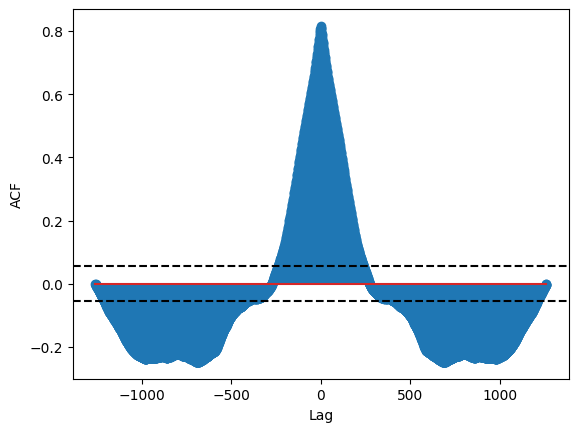

In [18]:
plt.stem(range(-len(ccf_output)//2, len(ccf_output)//2), ccf_output)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.axhline(-1.96/np.sqrt(len(data)), color='k', ls='--') 
plt.axhline(1.96/np.sqrt(len(data)), color='k', ls='--')

In [19]:
def ccf_finder(series1_symbol, series2_symbol, ccf_df):
    series1 = data_open[series1_symbol + '_Open']
    series2 = data_open[series2_symbol + '_Open']
    forwards = smt.ccf(series1, series2, adjusted=False)
    backwards = smt.ccf(series1, series2, adjusted=False)[::-1]
    output = np.r_[backwards[:-1], forwards]
    lag_range = range(-len(output)//2, len(output)//2)
    
    max_output = output[np.argmax(output)]
    max_lag = lag_range[np.argmax(output)]
    min_output = output[np.argmin(output)]
    min_lag = lag_range[np.argmin(output)]
    ccf_df.loc[len(ccf_df)] = (series1_symbol, series2_symbol,max_output, max_lag, min_output, min_lag)
    return ccf_df

In [20]:
ccf_apple_df = pd.DataFrame(columns=['stock1','stock2','max_ccf','max_ccf_lag','min_ccf','min_ccf_lag'])

for stock in stock_symbol_list:
    if stock != 'AAPL':
        ccf_apple_df = ccf_finder('AAPL', stock, ccf_apple_df)

In [21]:
ccf_apple_df.sort_values(by='max_ccf', ascending=False)

,stock1,stock2,max_ccf,max_ccf_lag,min_ccf,min_ccf_lag
692,AAPL,FAST,0.958722,-1,-0.353687,-980
1243,AAPL,MSFT,0.957450,-1,-0.326265,-986
1396,AAPL,ODFL,0.950275,-1,-0.325775,-982
1225,AAPL,MPWR,0.947544,-1,-0.336482,-979
499,AAPL,CWST,0.945919,-1,-0.326350,-980
...,...,...,...,...,...,...
21,AAPL,AC,0.125866,-373,-0.148634,-605
1641,AAPL,RYTM,0.125223,-723,-0.304895,-400
1293,AAPL,NBR,0.118941,-1169,-0.292174,-797
972,AAPL,IOR,0.118379,-1,-0.106290,-162


In [22]:
stock_list_greater_point_five_corr_apple = ccf_apple_df['stock2'][(ccf_apple_df['max_ccf'] >= 0.5) & (ccf_apple_df['max_ccf_lag'] <= 10)]


In [23]:
len(stock_list_greater_point_five_corr_apple)

761

The list I created has 761 stocks that have a correlation value greater than 0.5 within 10 lag values of apple stock price.

In [24]:
stock_list_greater_point_five_corr_apple_open = [] 
[stock_list_greater_point_five_corr_apple_open.append(a + '_Open') for a in stock_list_greater_point_five_corr_apple.values]

stock_list_greater_point_five_corr_apple_volume = []
[stock_list_greater_point_five_corr_apple_volume.append(a + '_Volume') for a in stock_list_greater_point_five_corr_apple.values]

stock_list_greater_point_five_corr_apple_low = [] 
[stock_list_greater_point_five_corr_apple_low.append(a + '_Low') for a in stock_list_greater_point_five_corr_apple.values]

stock_list_greater_point_five_corr_apple_high = []
[stock_list_greater_point_five_corr_apple_high.append(a + '_High') for a in stock_list_greater_point_five_corr_apple.values]

stock_list_greater_point_five_corr_apple_close = []
[stock_list_greater_point_five_corr_apple_close.append(a + '_Close') for a in stock_list_greater_point_five_corr_apple.values]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [25]:
stock_list_greater_point_five_corr_apple_open.append('AAPL_Open')
stock_list_greater_point_five_corr_apple_volume.append('AAPL_Volume')
stock_list_greater_point_five_corr_apple_low.append('AAPL_Low')
stock_list_greater_point_five_corr_apple_high.append('AAPL_High')
stock_list_greater_point_five_corr_apple_close.append('AAPL_Close')


### Univariate data prediction

In [26]:
def split_sequence(sequence, n_steps):
    X, y = [],[]
    for i in range(len(sequence)):
        end_idx = i + n_steps
        if end_idx > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [27]:
n_steps=10
apple_open_x, apple_open_y = split_sequence(apple_open.to_numpy(), n_steps)

In [28]:
apple_open_x_train = apple_open_x[0:1160]
apple_open_x_test = apple_open_x[1160:]

apple_open_y_train = apple_open_y[0:1160]
apple_open_y_test = apple_open_y[1160:]

In [29]:
n_features=1
model1 = Sequential([
    LSTM(10, activation='relu', input_shape=(n_steps, n_features)),
    Dense(1, activation='relu')
])

model1.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

In [30]:
model1.fit(x=apple_open_x_train, y=apple_open_y_train, validation_data=[apple_open_x_test,apple_open_y_test], epochs=10)

Epoch 1/10
37/37 [==============================] - 3s 27ms/step - loss: 10605.2764 - mse: 10605.2764 - mae: 94.3179 - val_loss: 8969.6260 - val_mse: 8969.6260 - val_mae: 94.6393
Epoch 2/10
37/37 [==============================] - 1s 22ms/step - loss: 1762.0975 - mse: 1762.0975 - mae: 36.1303 - val_loss: 87.3288 - val_mse: 87.3288 - val_mae: 8.0635
Epoch 3/10
37/37 [==============================] - 1s 23ms/step - loss: 41.9393 - mse: 41.9393 - mae: 5.1456 - val_loss: 23.2424 - val_mse: 23.2424 - val_mae: 4.2238
Epoch 4/10
37/37 [==============================] - 1s 22ms/step - loss: 22.6273 - mse: 22.6273 - mae: 3.5538 - val_loss: 11.7338 - val_mse: 11.7338 - val_mae: 2.9181
Epoch 5/10
37/37 [==============================] - 1s 23ms/step - loss: 11.5230 - mse: 11.5230 - mae: 2.6678 - val_loss: 5.9323 - val_mse: 5.9323 - val_mae: 1.9840
Epoch 6/10
37/37 [==============================] - 1s 26ms/step - loss: 9.9245 - mse: 9.9245 - mae: 2.4353 - val_loss: 7.3936 - val_mse: 7.3936 - val

| model results | model1 - apple only|
| :----- | :-----|
| Lags | 10 |
| LSTM | 10 |
| epochs | 10 |
| train mae | 122 |
| test mae | 186 |
| train mse | 16881 |
| test mse | 34747 |
| ------- | model2 - apple only |
| Lags | 50 |
| LSTM | 10 |
| epochs | 10 |
| train mae | 118 |
| test mae | 185 |
| train mse | 17124 |
| test mse | 185 |




# Following tensorflow tutorial at https://www.tensorflow.org/tutorials/structured_data/time_series#the_weather_dataset

Will be using the difference of the stocks for making the predictions and predicting apple stock difference

In [31]:
n_features_selected = 761  ### This is all features that correlate with apple within 10 lags greater than 0.5 before taking the difference
data_only_apple_corr = data_open[stock_list_greater_point_five_corr_apple_open[0:n_features_selected]]
try:
    data_only_apple_corr = data_only_apple_corr.drop(['AAPL_Open'])
except:
    pass
data_only_apple_corr['AAPL_Open'] = data_open['AAPL_Open'].copy()


C:\Users\lvden\AppData\Local\Temp\ipykernel_17176\2788200610.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_only_apple_corr['AAPL_Open'] = data_open['AAPL_Open'].copy()
C:\Users\lvden\AppData\Local\Temp\ipykernel_17176\2788200610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_only_apple_corr['AAPL_Open'] = data_open['AAPL_Open'].copy()


In [32]:
### Data Adjustments
differencing_flag = True
standardize_flag = True
day_of_year_flag = True
day_of_week_flag = True

volume_all_stocks_flag = True 
low_all_stocks_flag = True
high_all_stocks_flag = True

lstm_units = 80

### Differencing
if differencing_flag == True:
    data_only_apple_corr = data_only_apple_corr.diff().dropna()


if day_of_year_flag == True:
    day_of_year_list = []
    for val in data_only_apple_corr.index:
        day_of_year = pd.Period(val).day_of_year
        day_of_year_list.append(day_of_year)
    data_only_apple_corr['day_of_year'] = day_of_year_list

if day_of_week_flag == True:
    day_of_week_list = []
    for val in data_only_apple_corr.index:
        day_of_week = pd.Period(val).day_of_week
        day_of_week_list.append(day_of_week)
    data_only_apple_corr['day_of_week'] = day_of_week_list

if volume_all_stocks_flag == True:
    data_only_apple_corr = pd.merge(data_only_apple_corr, 
                                    data_volume[stock_list_greater_point_five_corr_apple_volume[0:n_features_selected]],
                                   on='Date')
if low_all_stocks_flag == True:
    data_only_apple_corr = pd.merge(data_only_apple_corr, 
                                    data_low[stock_list_greater_point_five_corr_apple_low[0:n_features_selected]],
                                   on='Date')

if high_all_stocks_flag == True:
    data_only_apple_corr = pd.merge(data_only_apple_corr, 
                                    data_high[stock_list_greater_point_five_corr_apple_high[0:n_features_selected]],
                                   on='Date')


C:\Users\lvden\AppData\Local\Temp\ipykernel_17176\4281901595.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_only_apple_corr['day_of_year'] = day_of_year_list
C:\Users\lvden\AppData\Local\Temp\ipykernel_17176\4281901595.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_only_apple_corr['day_of_week'] = day_of_week_list


In [33]:
column_indices = {name: i for i, name in enumerate(data_only_apple_corr.columns)}


n = len(data_only_apple_corr)
train_df = data_only_apple_corr[0:int(n*0.7)]
val_df = data_only_apple_corr[int(n*0.7):int(n*0.9)]
test_df = data_only_apple_corr[int(n*0.9):]

num_features = data_only_apple_corr.shape[1]


In [34]:
if standardize_flag == True:
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

In [35]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [36]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [37]:
def plot(self, model=None, plot_col='AAPL_Open', max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

In [38]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [39]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


### Creating a naive baseline model that predicts the previous value as the next value 

In [40]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [41]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['AAPL_Open'])
single_step_window


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AAPL_Open']

In [42]:
baseline = Baseline(label_index=column_indices['AAPL_Open'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.MeanAbsolutePercentageError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)


8/8 [==============================] - 0s 3ms/step - loss: 2.4224 - mean_absolute_error: 1.1933 - mean_absolute_percentage_error: 4096.6313


In [43]:
wide_window = WindowGenerator(
    input_width=10, label_width=1, shift=1,
    label_columns=['AAPL_Open'])

wide_window


Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['AAPL_Open']

### Multivariate model first pass through with model parameters printed below performance.

In [44]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1),
])


In [45]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                        tf.keras.metrics.MAPE])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [46]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)
print(performance)

8/8 [==============================] - 0s 4ms/step - loss: 1.1978 - mean_absolute_error: 0.8650 - mean_absolute_percentage_error: 861.6695
{'Baseline': {'loss': 2.0856449604034424, 'mean_absolute_error': 1.005099892616272, 'mean_absolute_percentage_error': 896.5127563476562}, 'LSTM': {'loss': 0.9011757969856262, 'mean_absolute_error': 0.7085373401641846, 'mean_absolute_percentage_error': 262.1198425292969}}


In [47]:
# wide_window.plot(lstm_model)
# plt.suptitle('Three random predictions')
# plt.show

### Model and data parameters used for this model

In [48]:
for key in performance:
    for key2 in performance[key]:
        performance[key][key2] = np.round(performance[key][key2], 5)

In [49]:
print(performance)
print('standardize: ' + str(standardize_flag))
print('differencing: ' + str(differencing_flag))
print('day_of_year:' + str(day_of_year_flag))
print('day of week: ' + str(day_of_week_flag))
print('volume: ' + str(volume_all_stocks_flag))
print('high: ' + str(high_all_stocks_flag))
print('low: ' + str(low_all_stocks_flag))
print('num features: ' + str(n_features_selected))
print('LSTM units: ' + str(lstm_units))

{'Baseline': {'loss': 2.08564, 'mean_absolute_error': 1.0051, 'mean_absolute_percentage_error': 896.51276}, 'LSTM': {'loss': 0.90118, 'mean_absolute_error': 0.70854, 'mean_absolute_percentage_error': 262.11984}}
standardize: True
differencing: True
day_of_year:True
day of week: True
volume: True
high: True
low: True
num features: 761
LSTM units: 80


## Function to conduct a grid search of model parameters

In [50]:
def lstm_apple_modeling_v4(data_open, stock_list_greater_point_five_corr_apple_open,
                        stock_list_greater_point_five_corr_apple_volume,
                        stock_list_greater_point_five_corr_apple_low,
                        stock_list_greater_point_five_corr_apple_high,    
                        stock_list_greater_point_five_corr_apple_close,
                        aux_data,
                        n_features_selected,
                       differencing_flag, standardize_flag, aux_data_flag, day_of_year_flag, day_of_week_flag,
                       volume_all_stocks_flag, low_all_stocks_flag, high_all_stocks_flag, close_all_stocks_flag, lstm_units,
                          lag_len = 10):

    '''VERSION 4 INCLUDES THE CLOSED SALE PRICE AND ABILITY TO INCREASE LAG SIZE
        data_open is the data frame data_open
       stock_list_greater_point_five_corr_apple_open is stock_list_greater_point_five_corr_apple_open
       n_features_selected is between 1 and 761
       all flags are booleans
       lstm_units is the number of units in the lstm'''
    ### Original data and the number of additional points that we want
    n_features_selected = n_features_selected
    data_only_apple_corr = data_open[stock_list_greater_point_five_corr_apple_open[0:n_features_selected]]
    try:
        data_only_apple_corr = data_only_apple_corr.drop(['AAPL_Open'])
    except:
        pass
    data_only_apple_corr['AAPL_Open'] = data_open['AAPL_Open'].copy()

    ### Data Adjustments
    differencing_flag = differencing_flag
    standardize_flag = standardize_flag
    day_of_year_flag = day_of_year_flag
    day_of_week_flag = day_of_week_flag
    
    volume_all_stocks_flag = volume_all_stocks_flag 
    low_all_stocks_flag = low_all_stocks_flag
    high_all_stocks_flag = high_all_stocks_flag
    
    lstm_units = lstm_units
    
    ### Differencing
    if differencing_flag == True:
        data_only_apple_corr = data_only_apple_corr.diff().dropna()
    
    ### Introducing new features
    if aux_data_flag == True:
        aux_data2 = aux_data.copy()
        ### Need to replace string dollar signs as ints
        sales_list = []
        [sales_list.append(int(float(a.split('$')[1].strip().split(',')[0] + a.split('$')[1].strip().split(',')[1]))) for a in aux_data2[' Sales ']]
        freecashflow_list = []
        [freecashflow_list.append(int(float(a.split('$')[1].strip().split(',')[0] + a.split('$')[1].strip().split(',')[1]))) for a in aux_data2[' FreeCashFlow ']]
        cash_list = []
        [cash_list.append(int(float(a.split('$')[1].strip().split(',')[0] + a.split('$')[1].strip().split(',')[1]))) for a in aux_data2[' Cash ']]
        debt_list = []
        [debt_list.append(int(float(a.split('$')[1].strip().split(',')[0] + a.split('$')[1].strip().split(',')[1]))) for a in aux_data2[' Long Term Debt ']]
        
        aux_data2[' Sales '] = sales_list
        aux_data2[' FreeCashFlow '] = freecashflow_list
        aux_data2[' Cash '] = cash_list
        aux_data2[' Long Term Debt '] = debt_list

        aux_data2 = aux_data2.rename({' Sales ':'Sales', list(aux_data2.columns)[2]:'FreeCashFlow', ' Cash ':'Cash', list(aux_data2.columns)[4]:'LongTermDebt'})
        date_list = []
        [date_list.append(pd.to_datetime(a).date()) for a in aux_data2['Date']] ### Need to change the dates to same object to match and 
        ### change back the date object in the primary dataframe to continue merging with the rest of the data
        aux_data2['Date'] = date_list
        aux_data2 = aux_data2.set_index('Date')
        aux_data_sub = aux_data2[aux_data2.index >=  pd.to_datetime(min(data_only_apple_corr.index)).date()]
        ### aux_data has older entries, so only want the entries on the dates we have stock data for
        date_list = []
        [date_list.append(pd.to_datetime(a).date()) for a in list(data_only_apple_corr.index)]
        old_index = list(data_only_apple_corr.index)
        data_only_apple_corr['Date'] = date_list
        data_only_apple_corr = data_only_apple_corr.set_index('Date')
        data_only_apple_corr = pd.merge(data_only_apple_corr, aux_data_sub, on='Date', how='left').ffill().bfill()
        data_only_apple_corr = data_only_apple_corr.set_index(pd.Series(old_index, name='Date'))


    if day_of_year_flag == True:
        day_of_year_list = []
        for val in data_only_apple_corr.index:
            day_of_year = pd.Period(val).day_of_year
            day_of_year_list.append(day_of_year)
        data_only_apple_corr['day_of_year'] = day_of_year_list
    
    if day_of_week_flag == True:
        day_of_week_list = []
        for val in data_only_apple_corr.index:
            day_of_week = pd.Period(val).day_of_week
            day_of_week_list.append(day_of_week)
        data_only_apple_corr['day_of_week'] = day_of_week_list
    
    if volume_all_stocks_flag == True:
        data_only_apple_corr = pd.merge(data_only_apple_corr, 
                                        data_volume[stock_list_greater_point_five_corr_apple_volume[0:n_features_selected]],
                                       on='Date')
    if low_all_stocks_flag == True:
        data_only_apple_corr = pd.merge(data_only_apple_corr, 
                                        data_low[stock_list_greater_point_five_corr_apple_low[0:n_features_selected]],
                                       on='Date')
    
    if high_all_stocks_flag == True:
        data_only_apple_corr = pd.merge(data_only_apple_corr, 
                                        data_high[stock_list_greater_point_five_corr_apple_high[0:n_features_selected]],
                                       on='Date')
    if close_all_stocks_flag == True:
        data_only_apple_corr = pd.merge(data_only_apple_corr,
                                       data_close[stock_list_greater_point_five_corr_apple_close[0:n_features_selected]],
                                       on='Date')

    column_indices = {name: i for i, name in enumerate(data_only_apple_corr.columns)}
    n = len(data_only_apple_corr)
    train_df = data_only_apple_corr[0:int(n*0.7)]
    val_df = data_only_apple_corr[int(n*0.7):int(n*0.9)]
    test_df = data_only_apple_corr[int(n*0.9):]
    num_features = data_only_apple_corr.shape[1]

    if standardize_flag == True:
        train_mean = train_df.mean()
        train_std = train_df.std()
        train_df = (train_df - train_mean) / train_std
        val_df = (val_df - train_mean) / train_std
        test_df = (test_df - train_mean) / train_std

    @property
    def train(self):
      return self.make_dataset(self.train_df)
    
    @property
    def val(self):
      return self.make_dataset(self.val_df)
    
    @property
    def test(self):
      return self.make_dataset(self.test_df)
    
    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result
    
    WindowGenerator.train = train
    WindowGenerator.val = val
    WindowGenerator.test = test
    WindowGenerator.example = example

    baseline = Baseline(label_index=column_indices['AAPL_Open'])
    
    baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                     metrics=[tf.keras.metrics.MeanAbsoluteError(),
                             tf.keras.metrics.MeanAbsolutePercentageError()])
    
    val_performance = {}
    performance = {}
    val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
    performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

    
    wide_window = WindowGenerator(
        input_width=10, label_width=10, shift=1,
        label_columns=['AAPL_Open'])

    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1),
    ])

    history = compile_and_fit(lstm_model, wide_window)

    IPython.display.clear_output()
    val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
    performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

    for key in performance:
        for key2 in performance[key]:
            performance[key][key2] = np.round(performance[key][key2], 5)

    return [n_features_selected, differencing_flag, standardize_flag, day_of_year_flag, day_of_week_flag,
            volume_all_stocks_flag, low_all_stocks_flag, high_all_stocks_flag, close_all_stocks_flag, 
            aux_data_flag, lstm_units, lag_len, performance]

In [51]:
output = lstm_apple_modeling_v4(data_open, 
        stock_list_greater_point_five_corr_apple_open = stock_list_greater_point_five_corr_apple_open,
        stock_list_greater_point_five_corr_apple_volume = stock_list_greater_point_five_corr_apple_volume,
        stock_list_greater_point_five_corr_apple_low = stock_list_greater_point_five_corr_apple_low,
        stock_list_greater_point_five_corr_apple_high = stock_list_greater_point_five_corr_apple_high,    
        stock_list_greater_point_five_corr_apple_close = stock_list_greater_point_five_corr_apple_close,
                                            aux_data = aux_data, n_features_selected = 761,
                                            differencing_flag = True, standardize_flag = True,
                                            aux_data_flag = True,
                                            day_of_year_flag = True, day_of_week_flag = True,
                                            volume_all_stocks_flag = True, low_all_stocks_flag = True, 
                                            high_all_stocks_flag = True, close_all_stocks_flag=True, 
                                            lstm_units=200, lag_len=10)

8/8 [==============================] - 0s 5ms/step - loss: 1.6224 - mean_absolute_error: 1.0304 - mean_absolute_percentage_error: 3231.2095


In [52]:
scores_baseline = output[12]['Baseline']
scores_lstm = output[12]['LSTM']
n_feat = output[0]
diff_f = output[1]
stand_f = output[2]
aux_f = output[9]
year_f = output[3]
week_f = output[4]
vol_f = output[5]
low_f = output[6]
high_f = output[7]
close_f = output[8]
lstm_units = output[10]
lag_len = output[11]

print(f'''Score is as follows: \nBASELINE {scores_baseline} \nLSTM     {scores_lstm} \n
Number of features selected: {n_feat} \n 
Differencing flag: {diff_f} \n
Standardization flag: {stand_f} \n
Auxilliary data flag: {aux_f} \n
Day of the year flag: {year_f} \n
Day of the week flag: {week_f} \n
Volume of stocks flag: {vol_f} \n
Low of stocks flag: {low_f} \n
High of stocks flag: {high_f} \n
Close of all stocks flag: {close_f} \n
LSTM units: {lstm_units} \n
Number of lags: {lag_len}''')

Score is as follows: 
BASELINE {'loss': 2.08564, 'mean_absolute_error': 1.0051, 'mean_absolute_percentage_error': 896.51276} 
LSTM     {'loss': 1.65308, 'mean_absolute_error': 1.04533, 'mean_absolute_percentage_error': 649.24091} 

Number of features selected: 761 
 
Differencing flag: True 

Standardization flag: True 

Auxilliary data flag: True 

Day of the year flag: True 

Day of the week flag: True 

Volume of stocks flag: True 

Low of stocks flag: True 

High of stocks flag: True 

Close of all stocks flag: True 

LSTM units: 200 

Number of lags: 10


In [53]:
# if input('Are you sure you want to run this long function?') == 'y':
    

#     grid_search_df = pd.DataFrame(columns=['n_features_selected',
#                        'differencing_flag', 'standardize_flag', 'day_of_year_flag', 'day_of_week_flag',
#                        'volume_all_stocks_flag', 'low_all_stocks_flag', 'high_all_stocks_flag', 'close_all_stocks_flag',
#                                'aux_data','lstm_units','lag_length',
#                         'baseline--loss','LSTM--loss', 'baseline--MAE','LSTM--MAE','baseline--MAPE','LSTM--MAPE'])
    
#     # flag_range_diff = [False, True]
#     # flag_range_stand = [False, True]
#     flag_range_doy = [False, True]
#     flag_range_dow = [False, True]
#     flag_range_vol = [False, True]
#     flag_range_low = [False, True]
#     flag_range_high = [False, True]
#     flag_range_close = [False, True]
#     flag_range_aux = [False, True]
    
#     n_features_selected_range = 761
#     lstm_units_range = [16,32,64,128,200]
#     lag_length_range = [10,20,30]



    
    
#     total_number_search = 2**7*5*3
    
#     i=0
#     for flag_range_doy_val in flag_range_doy:
#         for flag_range_dow_val in flag_range_dow:
#             for flag_range_vol_val in flag_range_vol:
#                 for flag_range_low_val in flag_range_low:
#                     for flag_range_high_val in flag_range_high:
#                         for flag_range_close_val in flag_range_close:
#                             for flag_range_aux_val in flag_range_aux:
#                                 for lstm_units_range_val in lstm_units_range:
#                                     for lag_length_range_val in lag_length_range:
#                                         output = lstm_apple_modeling_v4(data_open = data_open, 
#                                                 stock_list_greater_point_five_corr_apple_open = stock_list_greater_point_five_corr_apple_open,
#                                                 stock_list_greater_point_five_corr_apple_volume = stock_list_greater_point_five_corr_apple_volume,
#                                                 stock_list_greater_point_five_corr_apple_low = stock_list_greater_point_five_corr_apple_low,
#                                                 stock_list_greater_point_five_corr_apple_high = stock_list_greater_point_five_corr_apple_high,    
#                                                 stock_list_greater_point_five_corr_apple_close = stock_list_greater_point_five_corr_apple_close,
#                                                 aux_data = aux_data, n_features_selected = n_features_selected_range,
#                                                 differencing_flag = True, standardize_flag = True,
#                                                 aux_data_flag = flag_range_aux_val,
#                                                 day_of_year_flag = flag_range_doy_val, day_of_week_flag = flag_range_dow_val,
#                                                 volume_all_stocks_flag = flag_range_vol_val, low_all_stocks_flag = flag_range_low_val, 
#                                                 high_all_stocks_flag = flag_range_high_val, close_all_stocks_flag=flag_range_close_val, 
#                                                 lstm_units=lstm_units_range_val, lag_len=lag_length_range_val)
#                                         i+=1
#                                         print('Percent complete: ' + str(np.round(i/total_number_search*100,3)))
#                                         grid_search_df.loc[len(grid_search_df)] = [output[0], output[1],output[2],output[3],output[4],
#                                           output[5],output[6], output[7],output[8], output[9], output[10],output[11],
#                                           output[12]['Baseline']['loss'],
#                                           output[12]['LSTM']['loss'],
#                                           output[12]['Baseline']['mean_absolute_error'],
#                                           output[12]['LSTM']['mean_absolute_error'],
#                                           output[12]['Baseline']['mean_absolute_percentage_error'],
#                                           output[12]['LSTM']['mean_absolute_percentage_error']]



In [54]:
# grid_search_df.shape

In [55]:
# grid_search_df.to_csv('LSTM_grid_search_results_v2.csv')

# Plot predictions with best performing model based upon grid search results

In [138]:
output = lstm_apple_modeling_v4(data_open, 
        stock_list_greater_point_five_corr_apple_open = stock_list_greater_point_five_corr_apple_open,
        stock_list_greater_point_five_corr_apple_volume = stock_list_greater_point_five_corr_apple_volume,
        stock_list_greater_point_five_corr_apple_low = stock_list_greater_point_five_corr_apple_low,
        stock_list_greater_point_five_corr_apple_high = stock_list_greater_point_five_corr_apple_high,    
        stock_list_greater_point_five_corr_apple_close = stock_list_greater_point_five_corr_apple_close,
                                            aux_data = aux_data, n_features_selected = 761,
                                            differencing_flag = True, standardize_flag = True,
                                            aux_data_flag = True,
                                            day_of_year_flag = True, day_of_week_flag = True,
                                            volume_all_stocks_flag = True, low_all_stocks_flag = True, 
                                            high_all_stocks_flag = True, close_all_stocks_flag=True, 
                                            lstm_units=128, lag_len=10)

8/8 [==============================] - 0s 7ms/step - loss: 1.9078 - mean_absolute_error: 1.1091 - mean_absolute_percentage_error: 1989.3237


In [139]:
test_performance = lstm_model.evaluate(wide_window.test, return_dict = True)

4/4 [==============================] - 0s 4ms/step - loss: 0.9012 - mean_absolute_error: 0.7085 - mean_absolute_percentage_error: 262.1199


In [140]:
labels = test_df['AAPL_Open']
labels.index = pd.to_datetime(labels.index, utc=True)


In [141]:
input_test_list = []
label_test_list = []

for input_test, label_test in wide_window.test:
    input_test_list.append(input_test)
    label_test_list.append(label_test)

In [142]:
pred_output_list = []
for batch in input_test_list:
    for row in batch:
        row2 = np.asarray(row).reshape(1,10,3047)
        pred_output_list.append(lstm_model.predict(row2))

1/1 [==============================] - 0s 18ms/step


In [143]:
pred_output_first_val_list = []
for a in pred_output_list:
    pred_output_first_val_list.append(a[0][0][0])

pred_series = pd.Series(pred_output_first_val_list, index = labels[10:].index)

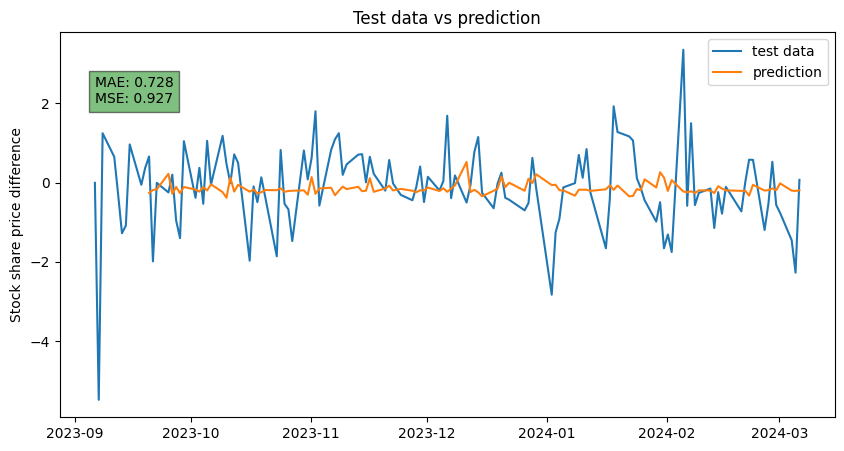

In [144]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

mae = 'MAE: ' + str(np.round(np.mean(np.abs(pred_series - labels[10:])),3))
mse = 'MSE: ' + str(np.round(np.mean((pred_series - labels[10:])**2),3))

ax.text(labels.index[0], 2, mae + '\n' + mse, bbox={'facecolor':'green', 'alpha':0.5})
ax.plot(labels, label='test data')
ax.plot(pred_series, label='prediction')
ax.legend()
ax.set_title('Test data vs prediction')
ax.set_ylabel('Stock share price difference')

plt.show()

# Plot the residuals and do the residual analysis

In [145]:
resid = labels[10:] - pred_series

<Figure size 1000x1000 with 0 Axes>

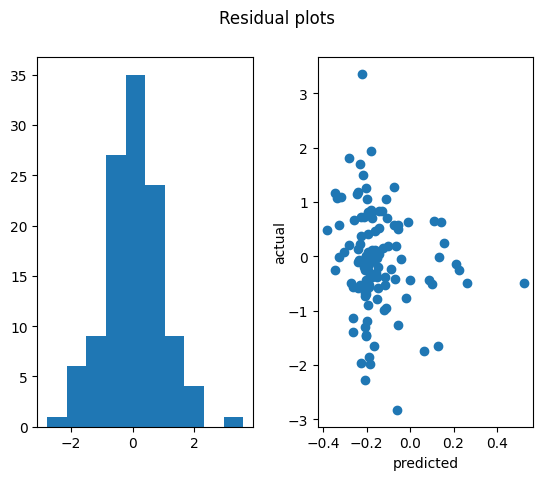

In [146]:
fig = plt.figure(figsize=(10,10))
f, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(resid)
ax2.scatter(pred_series,labels[10:])
ax2.set_xlabel('predicted')
ax2.set_ylabel('actual', labelpad=0)
plt.suptitle('Residual plots')
plt.subplots_adjust(wspace=0.3)
plt.show()

The histogram of the residuals appears normally distributed, however the scatterplot shows a bias towards a lower prediction of the stock difference value.

# Junkyard